# Multiclass Classification NN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob
from nltk import PorterStemmer

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.svm import SVC


from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling,margin_sampling,entropy_sampling

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

In [3]:
df = pd.read_pickle("../../dataset/final_dataset/nn_final.pkl")


,question,student_answer,grades_round,student_modified
0,"Give a definition for the term ""artificial ne...",An artificial neural network is a massively pa...,2,artificial neural network massively parallel d...
1,"Give a definition for the term ""artificial ne...",Artificial neural network consists of: . Large...,2,artificial neural network consists largely par...
2,"Give a definition for the term ""artificial ne...",An artificial neural network is a massive dist...,1,artificial neural network massive distributed ...
3,"Give a definition for the term ""artificial ne...",An ANN is a layered graphical model containing...,2,ann layered graphical model containing neuron ...
4,"Give a definition for the term ""artificial ne...",Artificial Neural Networks are large parallel ...,2,artificial neural network large parallel proce...
5,"Give a definition for the term ""artificial ne...",An articial neural network consists of neurons...,1,articial neural network consists neuron neuron...
6,"Give a definition for the term ""artificial ne...",An ANN is a - massivly parallel distibuted Pro...,2,ann massivly parallel distibuted processor mad...
7,"Give a definition for the term ""artificial ne...",A ANN is a massively distributed processor. It...,2,ann massively distributed processor propensity...
8,"Give a definition for the term ""artificial ne...",An artificial neural network is defined as a l...,2,artificial neural network defined learning mac...
9,"Give a definition for the term ""artificial ne...",An artificial neural network is a graph of sma...,2,artificial neural network graph small identica...


### Supervised Learning

In [3]:
class Supervised_learner():
    def __init__(self,X,Y,model):
        self.X = X
        self.Y = Y
        self.model = model

    def learn(self):
        X_train,X_test,Y_train,Y_test = train_test_split(self.X,self.Y,test_size = 0.2)
        model = self.model
        model.fit(X_train, Y_train)
        model_accuracy = model.score(X_test, Y_test)
        model_pred = model.predict(X_test)
        model_f1 = f1_score(Y_test,model_pred,average ="weighted")
        return model_accuracy,model_f1

### Active learning

In [50]:
class Active_learner():
    def __init__(self,X,Y,model,data, percentage,query_method):
        self.X = X
        self.Y = Y
        self.short_df = data.copy()
        self.percent = percentage
        self.model = model
        self.query_method = query_method
        
    def learn(self):       
        # seeding
        classes = self.short_df['grades_round'].unique()
        seed_index = []
        for i in classes:
            seed_index.append(self.short_df['grades_round'][self.short_df['grades_round']==i].index[0])
        seed_index

        act_data = self.short_df.copy()
        accuracy_list = []

        # initialising
        train_idx = seed_index
        X_train = self.X[train_idx]
        y_train = self.Y[train_idx]

        # generating the pool
        X_pool = np.delete(self.X, train_idx, axis=0)
        y_pool = np.delete(self.Y, train_idx)

        act_data = act_data.drop(axis=0,index = train_idx)
        act_data.reset_index(drop = True,inplace=True)


        # initializing the active learner

        learner = ActiveLearner(
            estimator = self.model,
            X_training = X_train, y_training=y_train,
            query_strategy=self.query_method
        )

        # pool-based sampling
        n_queries = int(len(X)/(100/self.percent))
        for idx in range(n_queries):
            query_idx, query_instance = learner.query(X_pool)   
            learner.teach(
                X=X_pool[query_idx].reshape(1, -1),
                y=y_pool[query_idx].reshape(1, )
            )

            # remove queried instance from pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)

            act_data = act_data.drop(axis=0,index = query_idx)
            act_data.reset_index(drop=True, inplace=True)

            accuracy_list.append(learner.score(X_pool,y_pool))
#             print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
        print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data" )
        model_pred = model.predict(X_pool)
        model_f1 = f1_score(y_pool,model_pred,average='weighted')
        return accuracy_list,model_f1

## Sultan

In [ ]:
#creating inputs and labels for sultan
X = df[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X = np.array(X)
Y = df['grades_round'].values

models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(),SVC(kernel='linear' , probability=True),SVC(probability=True)]
dict_accuracy_al ={}
f1_score_list = []
for i,model in enumerate(models):
    ac = Active_learner(X,Y,model,df, 30)
    accuracy_list,f1 = ac.learn()
    dict_accuracy_al[i] = accuracy_list
    f1_score_list.append(f1_score)
    
dict_accuracy_sl= []    
#Logistic regression
lr_accuracy_list = []
lr_f1_list = []
for _ in range(1):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
    lr = LogisticRegression()
    lr.fit(X_train, Y_train)
    lr_accuracy = lr.score(X_test, Y_test)
    lr_pred = lr.predict(X_test)
    lr_f1 = f1_score(Y_test,lr_pred,average='weighted')
    lr_accuracy_list.append(lr_accuracy)
    lr_f1_list.append(lr_f1)
lr_accuracy_mean = np.mean(lr_accuracy_list)
lr_f1_mean = np.mean(lr_f1_list)
dict_accuracy_sl.append(lr_accuracy_mean)

# naive bayes classfier    
nb_accuracy_list = []
nb_f1_list = []
for _ in range(1):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
    nb = MultinomialNB()
    nb.fit(X_train, Y_train)
    nb_accuracy = nb.score(X_test, Y_test)
    nb_pred = nb.predict(X_test)
    nb_f1 = f1_score(Y_test,nb_pred,average='weighted')
    nb_accuracy_list.append(nb_accuracy)
    nb_f1_list.append(nb_f1)
nb_accuracy_mean = np.mean(nb_accuracy_list)
nb_f1_mean = np.mean(nb_f1_list)
dict_accuracy_sl.append(nb_accuracy_mean)



# randomforest classfier    
rf_accuracy_list = []
rf_f1_list = []
for _ in range(1):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    rf_accuracy = rf.score(X_test, Y_test)
    rf_pred = rf.predict(X_test)
    rf_f1 = f1_score(Y_test,rf_pred,average='weighted')
    rf_accuracy_list.append(rf_accuracy)
    rf_f1_list.append(rf_f1)
rf_accuracy_mean = np.mean(rf_accuracy_list)
rf_f1_mean = np.mean(rf_f1_list)
dict_accuracy_sl.append(rf_accuracy_mean)



# Linear SVC classfier    
lsvc_accuracy_list = []
lsvc_f1_list = []
for _ in range(1):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
    lsvc = SVC(kernel='linear',probability=True)
    lsvc.fit(X_train, Y_train)
    lsvc_accuracy = lsvc.score(X_test, Y_test)
    lsvc_pred = lsvc.predict(X_test)
    lsvc_f1 = f1_score(Y_test,lsvc_pred,average='weighted')
    lsvc_accuracy_list.append(lsvc_accuracy)
    lsvc_f1_list.append(lsvc_f1)
lsvc_accuracy_mean = np.mean(lsvc_accuracy_list)
lsvc_f1_mean = np.mean(lsvc_f1_list)
dict_accuracy_sl.append(lsvc_accuracy_mean)


# RBF_SVC   
rsvc_accuracy_list = []
rsvc_f1_list = []
for _ in range(1):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
    rsvc = SVC(probability=True)
    rsvc.fit(X_train, Y_train)
    rsvc_accuracy = rsvc.score(X_test, Y_test)
    rsvc_pred = rsvc.predict(X_test)
    rsvc_f1 = f1_score(Y_test,rsvc_pred,average='weighted')
    rsvc_accuracy_list.append(rsvc_accuracy)
    rsvc_f1_list.append(rsvc_f1)
rsvc_accuracy_mean = np.mean(rsvc_accuracy_list)
rsvc_f1_mean = np.mean(rsvc_f1_list)
dict_accuracy_sl.append(rsvc_accuracy_mean)


### Plotting

In [ ]:
fig = plt.figure(figsize=(18,20))

for i in range(0,5):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(np.linspace(0,len(dict_accuracy_al[0])-1, len(dict_accuracy_al[0]) ), \
            [dict_accuracy_sl[i] for _ in range(len(dict_accuracy_al[0]))])
    ax.plot(dict_accuracy_al[i])
    
plt.tight_layout()
plt.show()

In [ ]:
df.columns

## Bag of Words

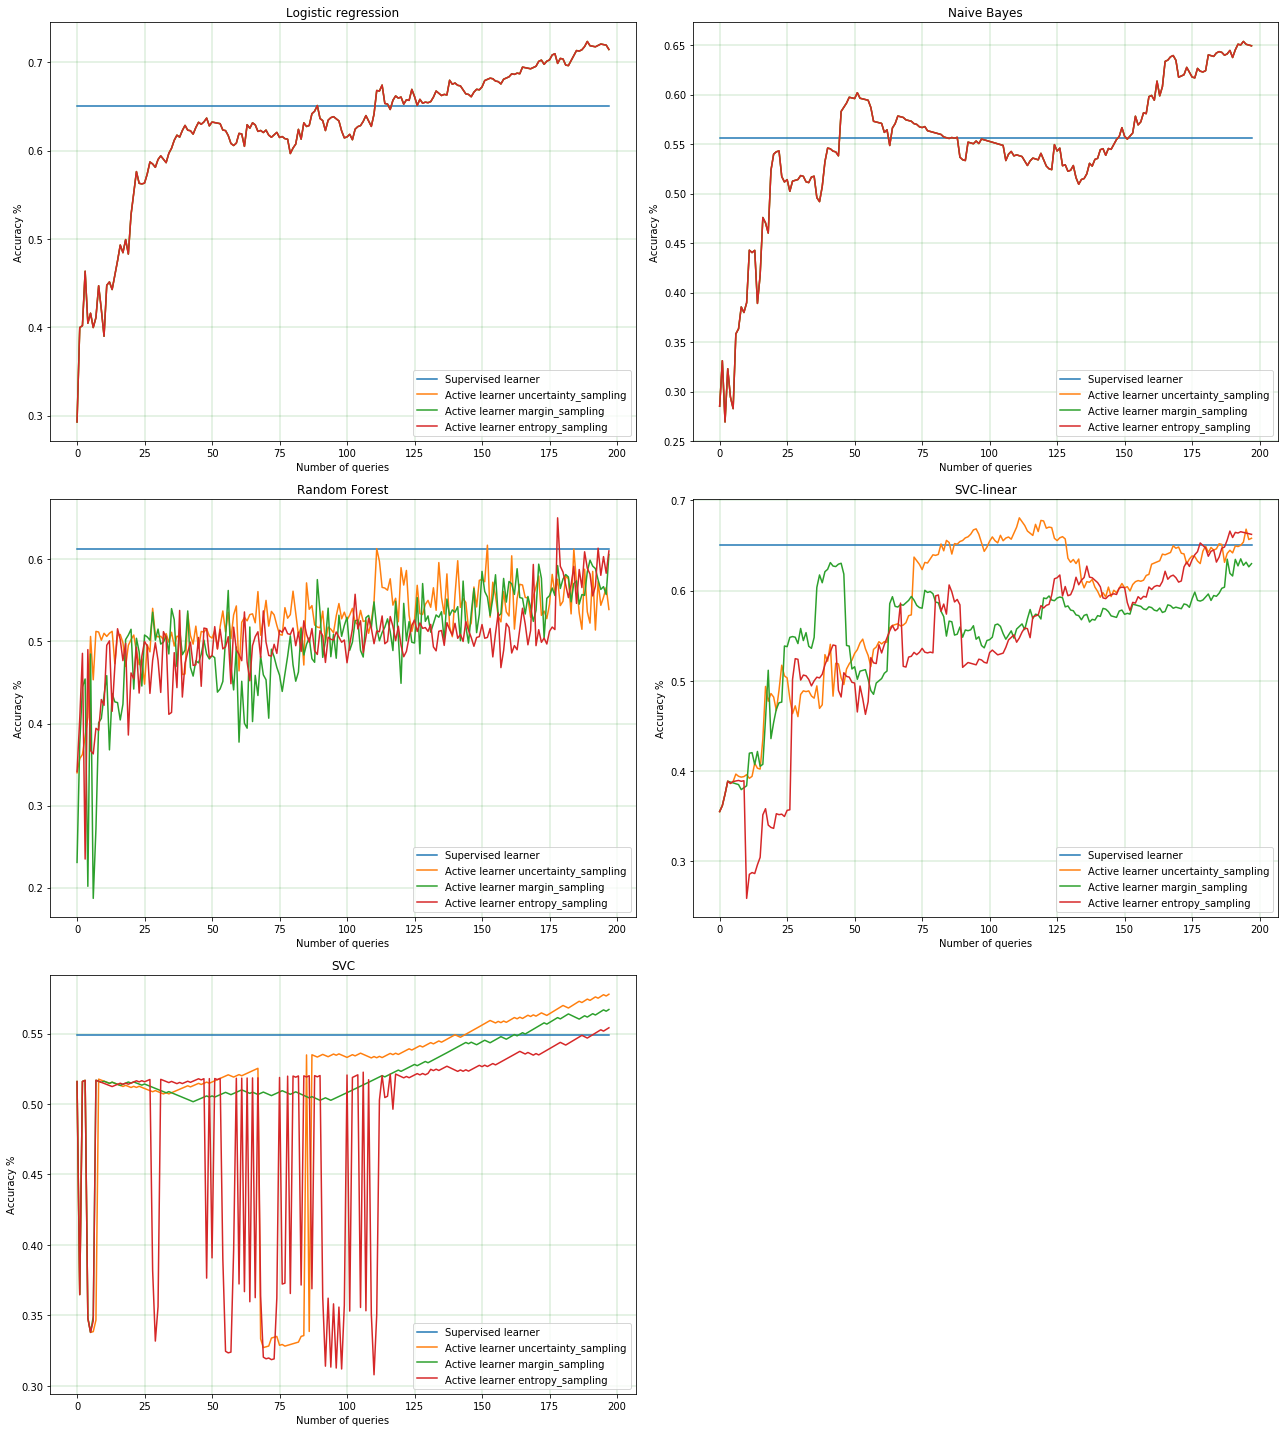

In [84]:
#creating inputs and labels for BOW
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = df['grades_round'].values

iteration_count = 2
Percent = 30

## Active learner
models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(),SVC(kernel='linear' , probability=True),SVC(probability=True)]
query_methods = [uncertainty_sampling,margin_sampling,entropy_sampling]
dict_accuracy_al ={}
f1_score_list = {}
for i,model in enumerate(models):
    dict_accuracy_al[i] = []
    f1_score_list[i] = []
    print("******************************************************************************")
    for query_method in query_methods:
        ac = Active_learner(X,Y,model,df, Percent,query_method)
        accuracy_list,f1 = ac.learn()
        dict_accuracy_al[i].append(accuracy_list)
        f1_score_list[i].append(f1_score)

    
## Supervised learner
dict_accuracy_sl= []
dict_f1_score_sl= []

for model in models:
    accuracy_list = []
    f1_list = []
    for _ in range(iteration_count):
        sl = Supervised_learner(X,Y,model)
        accuracy,f1score = sl.learn()
        accuracy_list.append(accuracy)
        f1_list.append(f1score)
    dict_accuracy_sl.append(np.mean(accuracy_list))
    dict_f1_score_sl.append(np.mean(f1_list))    

## plotting
fig = plt.figure(figsize=(18,20))
model_title = ["Logistic regression","Naive Bayes","Random Forest","SVC-linear","SVC"]
query_strategy = ["uncertainty_sampling","margin_sampling","entropy_sampling"]
for i in range(0,5):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(np.linspace(0,len(dict_accuracy_al[0][0])-1, len(dict_accuracy_al[0][0]) ), \
            [dict_accuracy_sl[i] for _ in range(len(dict_accuracy_al[0][0]))],label = "Supervised learner")
    for j in range(len(query_strategy)):
        ax.plot(dict_accuracy_al[i][j],label = "Active learner {}".format(query_strategy[j]))
    ax.legend(loc="lower right")
    ax.set_xlabel("Number of queries")
    ax.set_ylabel("Accuracy %")
    ax.set_title(model_title[i])
    ax.grid(color='g', linestyle='-', linewidth=0.2)
    
plt.tight_layout()
plt.show()

In [86]:
## storing the pikle
import pickle as pkl
dict_accuracy_al, f1_score_list , dict_accuracy_sl , dict_f1_score_sl
pkl.dump( dict_accuracy_al, open( "../../results/nn_bag_dict_accuracy_al.p", "wb" ) )
pkl.dump( f1_score_list, open( "../../results/nn_bag_f1_score_list.p", "wb" ) )
pkl.dump( dict_accuracy_sl, open( "../../results/nn_bag_dict_accuracy_sl.p", "wb" ) )
pkl.dump( dict_f1_score_sl, open( "../../results/nn_bag_dict_f1_score_sl.p", "wb" ) )

## Tf-IDf

******************************************************************************
By just labelling  29.86 % of total data accuracy of  0.695  % is achieved on the unseen data
By just labelling  29.86 % of total data accuracy of  0.695  % is achieved on the unseen data
By just labelling  29.86 % of total data accuracy of  0.695  % is achieved on the unseen data
******************************************************************************
By just labelling  29.86 % of total data accuracy of  0.673  % is achieved on the unseen data
By just labelling  29.86 % of total data accuracy of  0.673  % is achieved on the unseen data
By just labelling  29.86 % of total data accuracy of  0.673  % is achieved on the unseen data
******************************************************************************
By just labelling  29.86 % of total data accuracy of  0.563  % is achieved on the unseen data


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


By just labelling  29.86 % of total data accuracy of  0.569  % is achieved on the unseen data
By just labelling  29.86 % of total data accuracy of  0.602  % is achieved on the unseen data
******************************************************************************
By just labelling  29.86 % of total data accuracy of  0.68  % is achieved on the unseen data
By just labelling  29.86 % of total data accuracy of  0.669  % is achieved on the unseen data
By just labelling  29.86 % of total data accuracy of  0.604  % is achieved on the unseen data
******************************************************************************
By just labelling  29.86 % of total data accuracy of  0.554  % is achieved on the unseen data


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


By just labelling  29.86 % of total data accuracy of  0.532  % is achieved on the unseen data
By just labelling  29.86 % of total data accuracy of  0.552  % is achieved on the unseen data


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


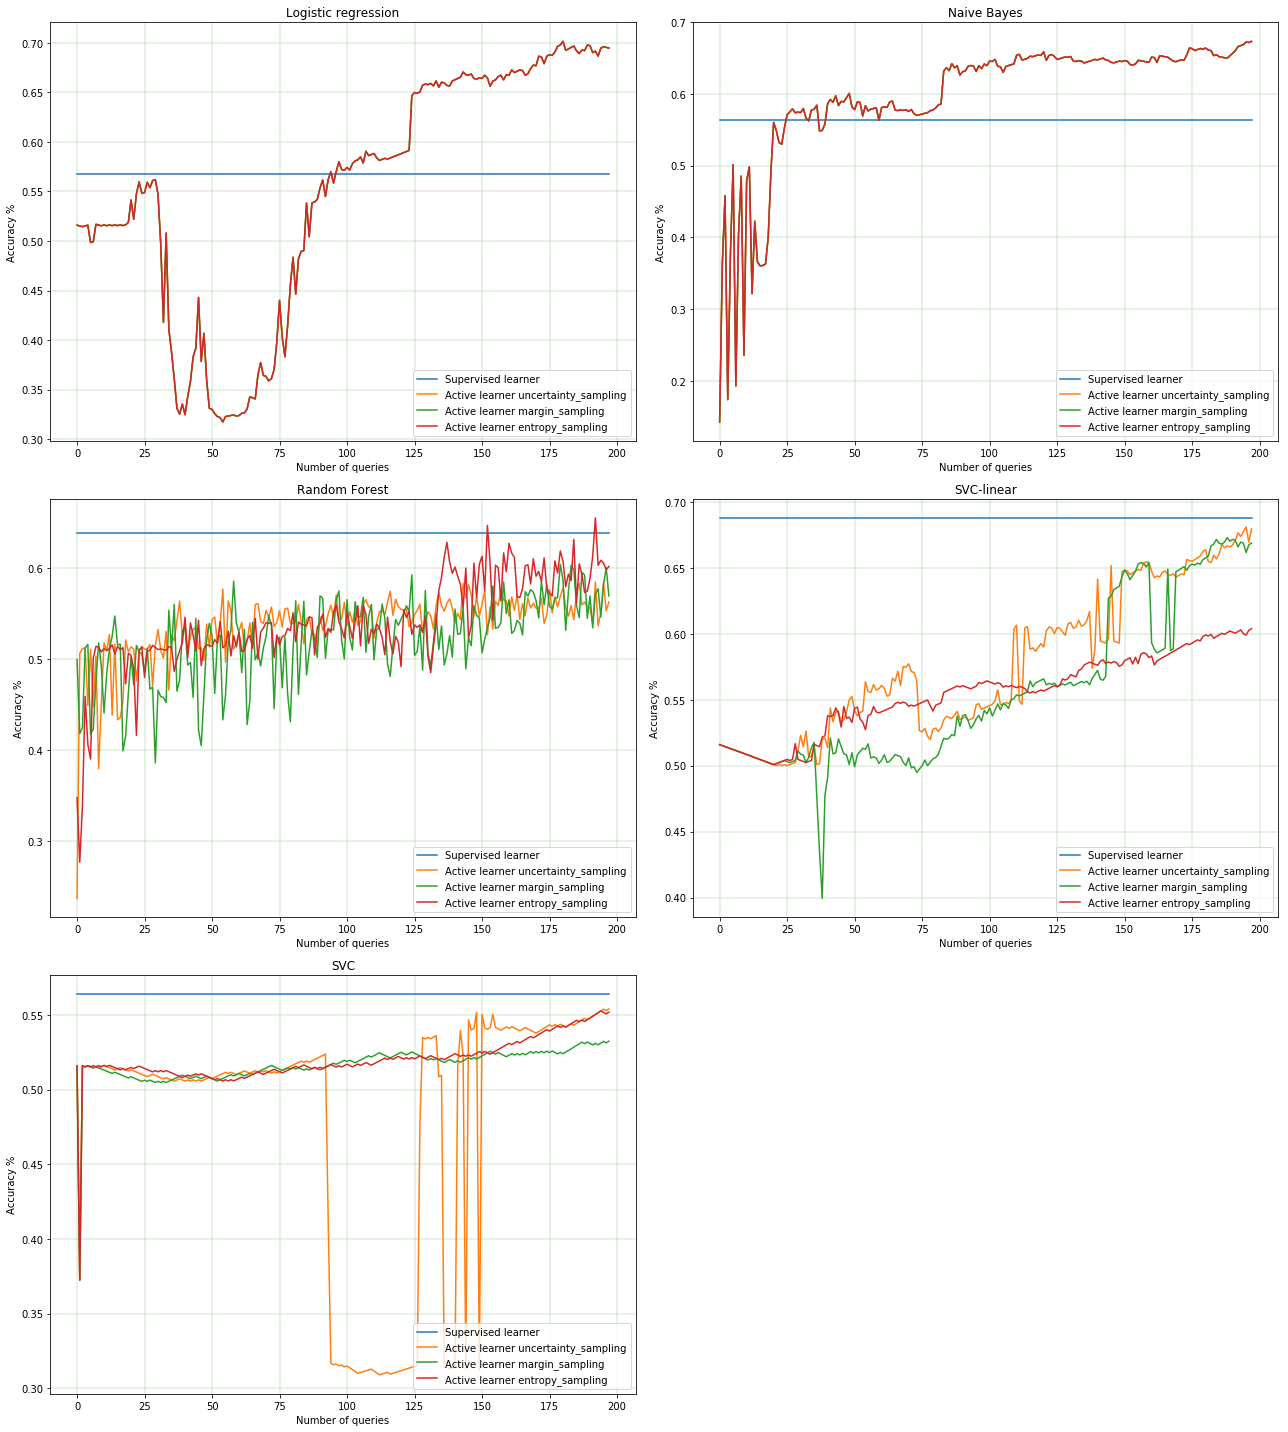

In [87]:
#creating inputs and labels for TFidf
Tf = TfidfVectorizer()
student_answer_count_vector = Tf.fit_transform(df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = df['grades_round'].values


iteration_count = 2
Percent = 30

## Active learner
models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(),SVC(kernel='linear' , probability=True),SVC(probability=True)]
query_methods = [uncertainty_sampling,margin_sampling,entropy_sampling]
dict_accuracy_al ={}
f1_score_list = {}
for i,model in enumerate(models):
    dict_accuracy_al[i] = []
    f1_score_list[i] = []
    print("******************************************************************************")
    for query_method in query_methods:
        ac = Active_learner(X,Y,model,df, Percent,query_method)
        accuracy_list,f1 = ac.learn()
        dict_accuracy_al[i].append(accuracy_list)
        f1_score_list[i].append(f1_score)

    
## Supervised learner
dict_accuracy_sl= []
dict_f1_score_sl= []

for model in models:
    accuracy_list = []
    f1_list = []
    for _ in range(iteration_count):
        sl = Supervised_learner(X,Y,model)
        accuracy,f1score = sl.learn()
        accuracy_list.append(accuracy)
        f1_list.append(f1score)
    dict_accuracy_sl.append(np.mean(accuracy_list))
    dict_f1_score_sl.append(np.mean(f1_list))    

## plotting
fig = plt.figure(figsize=(18,20))
model_title = ["Logistic regression","Naive Bayes","Random Forest","SVC-linear","SVC"]
query_strategy = ["uncertainty_sampling","margin_sampling","entropy_sampling"]
for i in range(0,5):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(np.linspace(0,len(dict_accuracy_al[0][0])-1, len(dict_accuracy_al[0][0]) ), \
            [dict_accuracy_sl[i] for _ in range(len(dict_accuracy_al[0][0]))],label = "Supervised learner")
    for j in range(len(query_strategy)):
        ax.plot(dict_accuracy_al[i][j],label = "Active learner {}".format(query_strategy[j]))
    ax.legend(loc="lower right")
    ax.set_xlabel("Number of queries")
    ax.set_ylabel("Accuracy %")
    ax.set_title(model_title[i])
    ax.grid(color='g', linestyle='-', linewidth=0.2)
    
plt.tight_layout()
plt.show()

## storing the pikle
import pickle as pkl
dict_accuracy_al, f1_score_list , dict_accuracy_sl , dict_f1_score_sl
pkl.dump( dict_accuracy_al, open( "../../results/nn_tfidf_dict_accuracy_al.p", "wb" ) )
pkl.dump( f1_score_list, open( "../../results/nn_tfidf_score_list.p", "wb" ) )
pkl.dump( dict_accuracy_sl, open( "../../results/nn_tfidf_dict_accuracy_sl.p", "wb" ) )
pkl.dump( dict_f1_score_sl, open( "../../results/nn_tfidf_dict_f1_score_sl.p", "wb" ) )

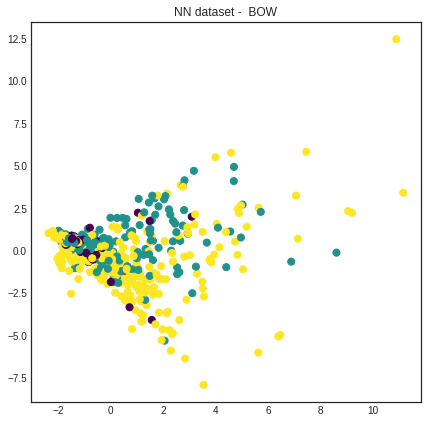

In [59]:

#creating inputs and labels for BOW
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = df['grades_round'].values


# visualizing the classes
with plt.style.context('seaborn-white'):
    pca = PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(7, 7))
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=Y, cmap='viridis', s=50)
    plt.title('NN dataset -  BOW')
    plt.show()
    

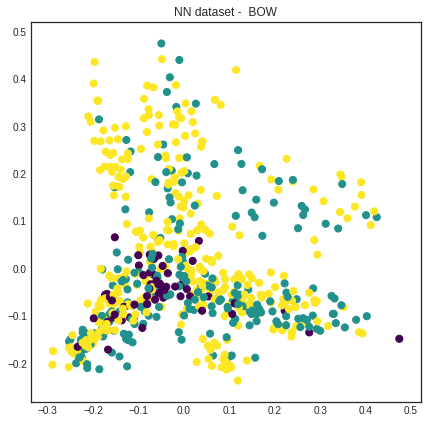

In [66]:

#creating inputs and labels for TFidf
Tf = TfidfVectorizer()
student_answer_count_vector = Tf.fit_transform(df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = df['grades_round'].values


# visualizing the classes
with plt.style.context('seaborn-white'):
    pca = PCA(n_components=3).fit_transform(X)
    plt.figure(figsize=(7, 7))
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=Y, cmap='viridis', s=50)
    plt.title('NN dataset -  TFIDF')
    plt.show()
    